In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Словарь файлов и соответствующих им названий столбцов
files = {
    'tksg.xlsx': 'TCSG',
    'yandex.xlsx': 'YDEX',
    'vk.xlsx': 'VKCO',
    'rostelecom.xlsx': 'RTKM',
    'usd_rub.xlsx': 'USD_RUB',
    'brent.xlsx': 'Brent',
    'bitcoin.xlsx': 'BTC_USD'
}


In [7]:
# 1. Импорт данных и обьединение в единый временной ряд методом inner join.
cleaned_df = None
for file, column_name in files.items():
    df = pd.read_excel(file)
    if 'Дата' not in df.columns or 'Значение' not in df.columns:
        raise KeyError(f"Столбцы 'Дата' или 'Значение' не найдены в файле {file}.")
    
    #перевод даты к пандасу и точки вместо запятых
    df['Date'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y')
    df[column_name] = df['Значение'].astype(str).str.replace(' ', '').str.replace(',', '.').astype(float)
    df = df[['Date', column_name]]
    df.set_index('Date', inplace=True)
    
    #принтуем каждый файл 3head-3tail
    print(f"\nДанные из файла {file} ({column_name}):")
    print(df.head(3))
    print(df.tail(3))
    print(f"Количество строк: {len(df)}")
    
    if cleaned_df is None:
        cleaned_df = df
    else:
        cleaned_df = cleaned_df.join(df, how='inner')

cleaned_df = cleaned_df[files.values()]
cleaned_df = cleaned_df.sort_index()

print("\nОбщие данные после объединения:")
print(cleaned_df.head())
print("\nРазмер данных:", cleaned_df.shape)
print("Диапазон дат:", cleaned_df.index.min(), "по", cleaned_df.index.max())


Данные из файла tksg.xlsx (TCSG):
              TCSG
Date              
2025-04-28  3279.8
2025-04-25  3284.4
2025-04-24  3212.0
              TCSG
Date              
2019-10-30  1217.0
2019-10-29  1219.8
2019-10-28  1206.0
Количество строк: 1353

Данные из файла yandex.xlsx (YDEX):
              YDEX
Date              
2025-04-28  4283.0
2025-04-25  4371.5
2025-04-24  4293.0
              YDEX
Date              
2018-04-30  2097.5
2018-04-28  2030.0
2018-04-27  2015.5
Количество строк: 1728

Данные из файла vk.xlsx (VKCO):
             VKCO
Date             
2025-04-28  272.9
2025-04-25  283.6
2025-04-24  272.8
              VKCO
Date              
2020-07-06  1852.0
2020-07-03  1754.8
2020-07-02  1666.0
Количество строк: 1183

Данные из файла rostelecom.xlsx (RTKM):
             RTKM
Date             
2025-04-28  59.85
2025-04-25  61.47
2025-04-24  60.94
             RTKM
Date             
2015-04-03  80.70
2015-04-02  80.42
2015-04-01  80.00
Количество строк: 2531

Данные из файла 

In [3]:
# 2. Очистка от выбросов (метод IQR)
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

columns_to_clean = list(files.values())
cleaned_df = remove_outliers(cleaned_df, columns_to_clean)
print("\nДанные после очистки от выбросов:")
print(cleaned_df.head())


Данные после очистки от выбросов:
              TCSG    YDEX    VKCO   RTKM  USD_RUB  Brent  BTC_USD
Date                                                              
2020-07-02  1447.0  3103.8  1666.0  87.63  70.4413  43.14  9123.41
2020-07-07  1490.0  3598.8  1873.0  88.00  71.3409  43.08  9252.28
2020-07-08  1460.0  4360.0  1838.6  86.60  72.1719  43.29  9428.33
2020-07-09  1470.2  4975.0  1808.0  85.60  71.2379  42.35  9277.97
2020-07-10  1504.4  4779.4  1811.8  87.03  70.8800  43.24  9278.81


In [4]:
# 3. Нормализация (Z-нормализация)
normalized_df = cleaned_df.copy()
for col in columns_to_clean:
    mean = cleaned_df[col].mean()
    std = cleaned_df[col].std()
    normalized_df[col] = (cleaned_df[col] - mean) / std
    print(f"\nСтатистика для {col} (до нормализации): mean = {mean:.2f}, std = {std:.2f}")

print("\nПример нормализованного датафрейма (первые 5 строк):")
print(normalized_df.head())


Статистика для TCSG (до нормализации): mean = 2918.69, std = 724.61

Статистика для YDEX (до нормализации): mean = 3273.07, std = 1172.63

Статистика для VKCO (до нормализации): mean = 846.34, std = 656.51

Статистика для RTKM (до нормализации): mean = 76.62, std = 17.09

Статистика для USD_RUB (до нормализации): mean = 80.00, std = 12.17

Статистика для Brent (до нормализации): mean = 76.92, std = 16.84

Статистика для BTC_USD (до нормализации): mean = 41082.61, std = 25516.96

Пример нормализованного датафрейма (первые 5 строк):
                TCSG      YDEX      VKCO      RTKM   USD_RUB     Brent  \
Date                                                                     
2020-07-02 -2.031027 -0.144350  1.248516  0.644141 -0.785456 -2.006478   
2020-07-07 -1.971685  0.277777  1.563822  0.665794 -0.711539 -2.010042   
2020-07-08 -2.013087  0.926915  1.511423  0.583863 -0.643259 -1.997569   
2020-07-09 -1.999010  1.451377  1.464813  0.525340 -0.720003 -2.053402   
2020-07-10 -1.9518

In [5]:
# 4. Проверка нормальности (тест Шапиро-Уилка)
print("\nПроверка нормальности (тест Шапиро-Уилка):")
for col in columns_to_clean:
    data = cleaned_df[col].dropna()
    if len(data) < 3:
        print(f"{col}: Недостаточно данных для теста.")
        continue
    stat, p = stats.shapiro(data)
    print(f"{col}: p-value = {p:.4f}")
    if p < 0.05:
        print(f" -> Распределение {col} не является нормальным (p < 0.05).")

print("Тест Шапиро-Уилка завершен. Переходим к следующим шагам...")


Проверка нормальности (тест Шапиро-Уилка):
TCSG: p-value = 0.0000
 -> Распределение TCSG не является нормальным (p < 0.05).
YDEX: p-value = 0.0000
 -> Распределение YDEX не является нормальным (p < 0.05).
VKCO: p-value = 0.0000
 -> Распределение VKCO не является нормальным (p < 0.05).
RTKM: p-value = 0.0000
 -> Распределение RTKM не является нормальным (p < 0.05).
USD_RUB: p-value = 0.0000
 -> Распределение USD_RUB не является нормальным (p < 0.05).
Brent: p-value = 0.0000
 -> Распределение Brent не является нормальным (p < 0.05).
BTC_USD: p-value = 0.0000
 -> Распределение BTC_USD не является нормальным (p < 0.05).
Тест Шапиро-Уилка завершен. Переходим к следующим шагам...



=== Корреляционный анализ (метод Спирмена) ===

Матрица корреляции (Спирмен):


,TCSG,YDEX,VKCO,RTKM,USD_RUB,Brent,BTC_USD
TCSG,1.000000,0.223000,0.157000,0.305000,0.368000,0.062000,0.509000
YDEX,0.223000,1.000000,0.492000,0.756000,0.234000,-0.696000,0.309000
VKCO,0.157000,0.492000,1.000000,0.768000,-0.069000,-0.493000,-0.366000
RTKM,0.305000,0.756000,0.768000,1.000000,0.184000,-0.519000,0.136000
USD_RUB,0.368000,0.234000,-0.069000,0.184000,1.000000,-0.094000,0.684000
Brent,0.062000,-0.696000,-0.493000,-0.519000,-0.094000,1.000000,0.004000
BTC_USD,0.509000,0.309000,-0.366000,0.136000,0.684000,0.004000,1.000000


C:\Users\DxDyBoss\AppData\Local\Temp\ipykernel_15088\3863695076.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


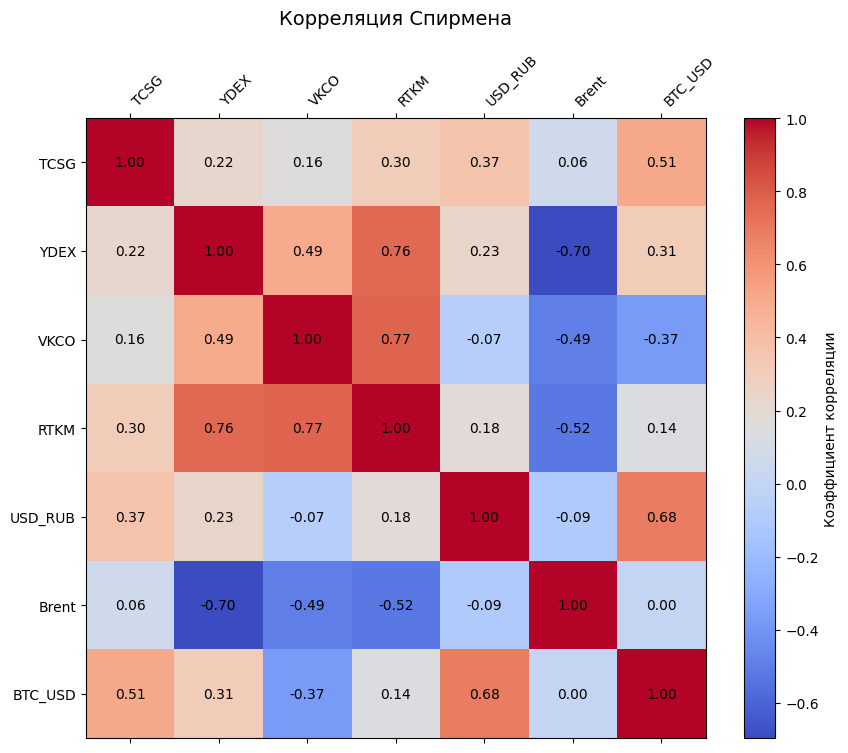

In [39]:
# 6.1. Корреляционный анализ (только Спирмен)
def analyze_correlations():
    print("\n=== Корреляционный анализ (метод Спирмена) ===")
    
    # Корреляция Спирмена
    correlation_matrix = normalized_df[columns_to_clean].corr(method='spearman')
    
    # Форматирование матрицы для вывода
    corr_df = correlation_matrix.round(3)  # Округляем до 3 знаков после запятой
    print("\nМатрица корреляции (Спирмен):")
    display(corr_df.style.background_gradient(cmap='coolwarm', axis=None).set_caption('Корреляционная матрица (Спирмен)'))

    # Визуализация корреляции
    plt.figure(figsize=(10, 8), dpi=100)
    plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
    plt.xticks(range(len(columns_to_clean)), columns_to_clean, rotation=45, ha='left')
    plt.yticks(range(len(columns_to_clean)), columns_to_clean)
    for (i, j), val in np.ndenumerate(correlation_matrix):
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)
    plt.title('Корреляция Спирмена', fontsize=14, pad=20)
    plt.colorbar(label='Коэффициент корреляции')
    plt.tight_layout()
    plt.show()

# Выполняем корреляционный анализ
analyze_correlations()


=== Регрессионный анализ ===

Модели обучены (линейная регрессия и Random Forest).
Выводим данные и графики только для линейной регрессии.

Уравнения линейной регрессии (для нормализованных данных):
TCSG_z = -0.0000 + 0.1036 * USD_RUB_z + 0.1178 * Brent_z + 0.2519 * BTC_USD_z
YDEX_z = 0.0000 + -0.1993 * USD_RUB_z + -0.7447 * Brent_z + 0.5710 * BTC_USD_z
VKCO_z = 0.0000 + -0.1444 * USD_RUB_z + -0.8004 * Brent_z + -0.1979 * BTC_USD_z
RTKM_z = 0.0000 + 0.0596 * USD_RUB_z + -0.5958 * Brent_z + 0.0296 * BTC_USD_z

Таблица коэффициентов линейной регрессии:


,Переменная,Пересечение,USD_RUB,Brent,BTC_USD
0,TCSG,-5.312953e-16,0.103623,0.117784,0.251947
1,YDEX,3.195043e-16,-0.199343,-0.744689,0.571030
2,VKCO,2.021967e-16,-0.144431,-0.800436,-0.197895
3,RTKM,2.048890e-16,0.059626,-0.595778,0.029643



Графики фактических и прогнозируемых значений (линейная регрессия):


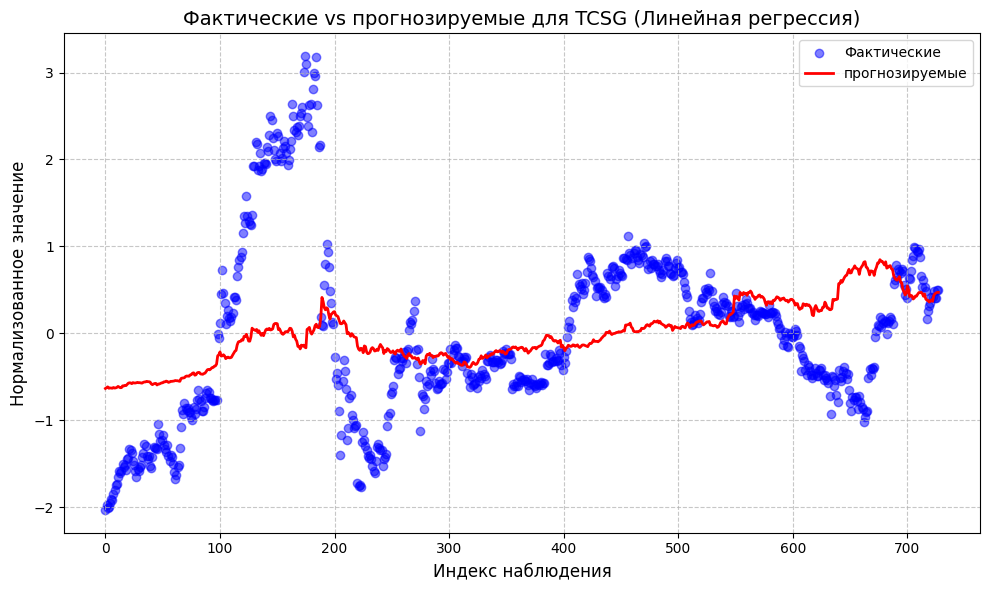

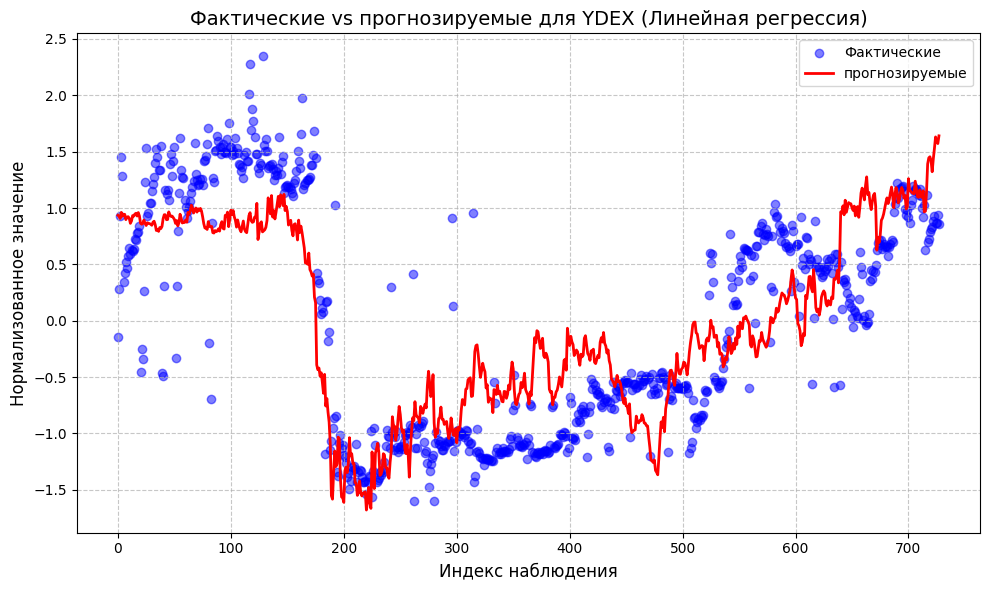

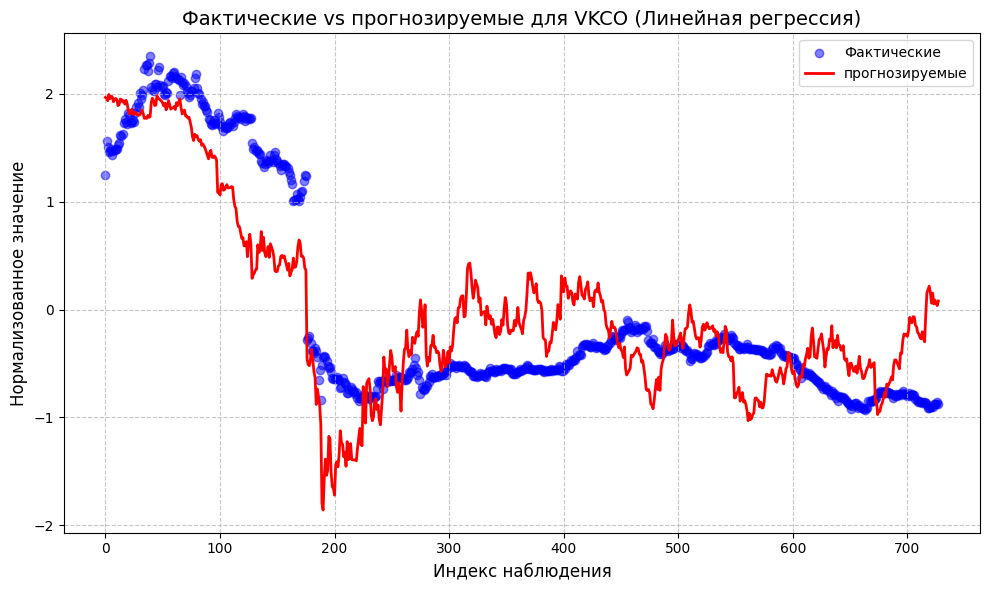

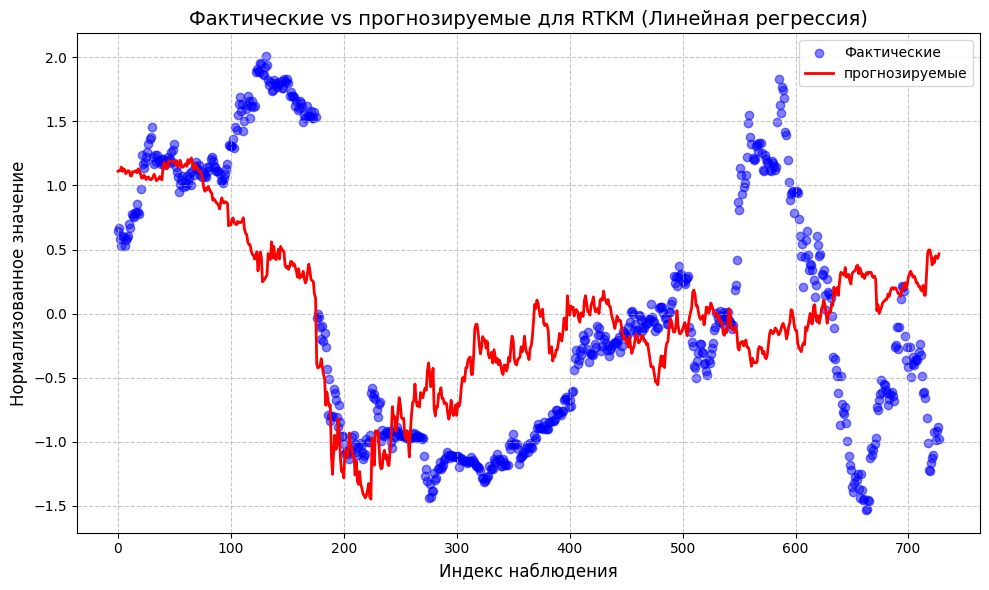

In [42]:
# Предполагается, что normalized_df, dependent_vars, independent_vars, X, results уже определены

# 6.2. Регрессионный анализ (линейная для вывода, Random Forest для модели)
def analyze_regression():
    print("\n=== Регрессионный анализ ===")
    
    # Обучение моделей (линейная и Random Forest)
    global results  # Делаем results глобальной, чтобы использовать в следующем блоке
    results = {}
    for y_var in dependent_vars:
        y = normalized_df[y_var]
        # Линейная регрессия
        linear_model = LinearRegression()
        linear_model.fit(X, y)
        # Random Forest (только для модели, без вывода)
        forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
        forest_model.fit(X, y)
        # Сохраняем обе модели для дальнейшего использования
        results[y_var] = {
            'linear': linear_model,
            'forest': forest_model
        }
    
    print("\nМодели обучены (линейная регрессия и Random Forest).")
    print("Выводим данные и графики только для линейной регрессии.\n")

    # Регрессионный анализ (только для линейной регрессии)
    coef_table = []
    equations = []

    for y_var in dependent_vars:
        model = results[y_var]['linear']  # Только линейная регрессия
        coefs = dict(zip(independent_vars, model.coef_))
        intercept = model.intercept_
        # Формируем уравнение
        equation = f"{y_var}_z = {intercept:.4f}"
        for var, coef in coefs.items():
            equation += f" + {coef:.4f} * {var}_z"
        equations.append(equation)
        
        # Добавляем в таблицу
        coef_table.append({
            'Переменная': y_var,
            'Пересечение': intercept,
            **{var: coef for var, coef in coefs.items()}
        })

    # Вывод уравнений
    print("Уравнения линейной регрессии (для нормализованных данных):")
    for eq in equations:
        print(eq)

    # Вывод таблицы коэффициентов
    coef_df = pd.DataFrame(coef_table)
    print("\nТаблица коэффициентов линейной регрессии:")
    display(coef_df)

    # Графики: фактические vs прогнозируемые значения (только для линейной регрессии)
    print("\nГрафики фактических и прогнозируемых значений (линейная регрессия):")
    for y_var in dependent_vars:
        model = results[y_var]['linear']
        y_true = normalized_df[y_var]
        y_pred = model.predict(X)
        
        plt.figure(figsize=(10, 6), dpi=100)
        plt.scatter(range(len(y_true)), y_true, label='Фактические', alpha=0.5, color='blue')
        plt.plot(range(len(y_pred)), y_pred, color='red', label='прогнозируемые', linewidth=2)
        plt.title(f'Фактические vs прогнозируемые для {y_var} (Линейная регрессия)', fontsize=14)
        plt.xlabel('Индекс наблюдения', fontsize=12)
        plt.ylabel('Нормализованное значение', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Выполняем регрессионный анализ
analyze_regression()

In [38]:
# 6.4. Анализ дисперсии (ANOVA) для линейной регрессии
def anova_analysis():
    print("\n=== Анализ дисперсии (ANOVA) ===")
    print("Оцениваем статистическую значимость линейной регрессии.\n")
    
    # Подготовка данных
    data = normalized_df.copy()
    
    # Таблица ANOVA для каждой зависимой переменной
    anova_tables = []
    
    for y_var in dependent_vars:
        # Формула для регрессии: y ~ x1 + x2 + x3
        formula = f"{y_var} ~ {' + '.join(independent_vars)}"
        model = smf.ols(formula, data=data).fit()  # Линейная регрессия с формульным интерфейсом
        anova_table = sm.stats.anova_lm(model, typ=1)  # ANOVA тип I (последовательный)
        
        # Форматируем таблицу ANOVA
        anova_table = anova_table.round(3)
        anova_tables.append({
            'Переменная': y_var,
            'ANOVA': anova_table
        })

    # Вывод таблиц ANOVA
    for item in anova_tables:
        y_var = item['Переменная']
        anova_df = item['ANOVA']
        # Оставляем только первую строку для общей регрессии и остатки
        anova_df = anova_df.iloc[[0, -1]]  # Берем первую строку (общая регрессия) и последнюю (остатки)
        anova_df.index = ['Регрессия', 'Остатки']  # Переименовываем индексы
        print(f"\nТаблица ANOVA для {y_var}:")
        styled_anova_df = anova_df.style.set_caption(f'ANOVA для {y_var}')\
                                       .background_gradient(cmap='Greens', subset=['F'])\
                                       .format({'sum_sq': '{:.3f}', 'df': '{:.0f}', 'F': '{:.3f}', 'PR(>F)': '{:.3f}'})
        display(styled_anova_df)

        # Интерпретация (для всей модели)
        f_stat = anova_df['F'].iloc[0]  # F-статистика для общей регрессии
        p_value = anova_df['PR(>F)'].iloc[0]  # p-значение для общей регрессии
        significance = 'значима' if p_value < 0.05 else 'незначима'
        print(f"Интерпретация для {y_var}: F = {f_stat:.3f}, p = {p_value:.3f} – модель {significance} (p < 0.05).")

# Выполняем ANOVA анализ
anova_analysis()


=== Анализ дисперсии (ANOVA) ===
Оцениваем статистическую значимость линейной регрессии.


Таблица ANOVA для TCSG:


,df,sum_sq,mean_sq,F,PR(>F)
Регрессия,1,49.528,49.528000,56.410,0.000
Остатки,724,635.674,0.878000,nan,nan


Интерпретация для TCSG: F = 56.410, p = 0.000 – модель значима (p < 0.05).

Таблица ANOVA для YDEX:


,df,sum_sq,mean_sq,F,PR(>F)
Регрессия,1,43.815,43.815000,133.280,0.000
Остатки,724,238.014,0.329000,nan,nan


Интерпретация для YDEX: F = 133.280, p = 0.000 – модель значима (p < 0.05).

Таблица ANOVA для VKCO:


,df,sum_sq,mean_sq,F,PR(>F)
Регрессия,1,30.966,30.966000,120.861,0.000
Остатки,724,185.497,0.256000,nan,nan


Интерпретация для VKCO: F = 120.861, p = 0.000 – модель значима (p < 0.05).

Таблица ANOVA для RTKM:


,df,sum_sq,mean_sq,F,PR(>F)
Регрессия,1,12.524,12.524000,19.642,0.000
Остатки,724,461.644,0.638000,nan,nan


Интерпретация для RTKM: F = 19.642, p = 0.000 – модель значима (p < 0.05).


In [27]:
# Предполагается, что normalized_df, dependent_vars, X, results уже определены

# 6.3. Дисперсионный анализ (R²) для линейной регрессии
def dispersion_analysis():
    print("\n=== Дисперсионный анализ (R²) ===")
    print("Оцениваем объяснительную способность линейной регрессии.\n")
    
    # Дисперсионный анализ (R²) (только для линейной регрессии)
    r2_table = []
    for y_var in dependent_vars:
        model = results[y_var]['linear']
        r2 = model.score(X, normalized_df[y_var])
        r2_table.append({
            'Переменная': y_var,
            'R²': r2
        })

    # Форматирование таблицы R²
    r2_df = pd.DataFrame(r2_table)
    r2_df['R²'] = r2_df['R²'].round(3)  # Округляем до 3 знаков после запятой
    r2_df['Объясненная дисперсия (%)'] = (r2_df['R²'] * 100).round(1)  # Процент объясненной дисперсии
    r2_df['Интерпретация'] = r2_df['R²'].apply(
        lambda x: 'Высокая' if x >= 0.7 else 'Средняя' if x >= 0.4 else 'Низкая'
    )  # Добавляем интерпретацию качества модели

    # Вывод таблицы R²
    print("Таблица дисперсионного анализа (R²) для линейной регрессии:")
    styled_r2_df = r2_df.style.set_caption('Дисперсионный анализ линейной регрессии')\
                              .background_gradient(cmap='Blues', subset=['R²'])\
                              .format({'R²': '{:.3f}', 'Объясненная дисперсия (%)': '{:.1f}%'})
    display(styled_r2_df)

    # Вывод интерпретации
    print("\nИнтерпретация результатов:")
    for _, row in r2_df.iterrows():
        print(f"- {row['Переменная']}: R² = {row['R²']:.3f} ({row['Объясненная дисперсия (%)']:.1f}%) – {row['Интерпретация']} предсказательная способность.")

# Выполняем дисперсионный анализ
dispersion_analysis()


=== Дисперсионный анализ (R²) ===
Оцениваем объяснительную способность линейной регрессии.

Таблица дисперсионного анализа (R²) для линейной регрессии:


,Переменная,R²,Объясненная дисперсия (%),Интерпретация
0,TCSG,0.126,12.6%,Низкая
1,YDEX,0.673,67.3%,Средняя
2,VKCO,0.745,74.5%,Высокая
3,RTKM,0.365,36.5%,Низкая



Интерпретация результатов:
- TCSG: R² = 0.126 (12.6%) – Низкая предсказательная способность.
- YDEX: R² = 0.673 (67.3%) – Средняя предсказательная способность.
- VKCO: R² = 0.745 (74.5%) – Высокая предсказательная способность.
- RTKM: R² = 0.365 (36.5%) – Низкая предсказательная способность.


In [25]:
# 7. Интерактивная визуализация (без переключения корреляции)
def interactive_visualization():
    def normalize_value(value, col):
        return (value - data_stats[col]['mean']) / data_stats[col]['std']

    def denormalize_value(z, col):
        return max(0, z * data_stats[col]['std'] + data_stats[col]['mean'])

    def predict_stock_prices(usd_rub_z, brent_z, btc_usd_z, reg_method):
        predictions = {}
        for y_var in dependent_vars:
            model = results[y_var][reg_method]
            if reg_method == 'linear':
                prediction = (model.intercept_ +
                              model.coef_[0] * usd_rub_z +
                              model.coef_[1] * brent_z +
                              model.coef_[2] * btc_usd_z)
            else:  # forest
                X_pred = pd.DataFrame(
                    [[usd_rub_z, brent_z, btc_usd_z]],
                    columns=independent_vars
                )
                prediction = model.predict(X_pred)[0]
            predictions[y_var] = prediction
        return predictions

    def update_plot(usd_rub, brent, btc_usd, reg_method):
        btc_usd_min = cleaned_df['BTC_USD'].min()
        btc_usd_max = cleaned_df['BTC_USD'].max()
        if btc_usd < btc_usd_min or btc_usd > btc_usd_max:
            print(f"Внимание: BTC/USD ({btc_usd} USD) выходит за диапазон данных ({btc_usd_min:.2f} ... {btc_usd_max:.2f} USD).")
            btc_usd = min(max(btc_usd, btc_usd_min), btc_usd_max)
        
        usd_rub_z = normalize_value(usd_rub, 'USD_RUB')
        brent_z = normalize_value(brent, 'Brent')
        btc_usd_z = normalize_value(btc_usd, 'BTC_USD')
        
        z_predictions = predict_stock_prices(usd_rub_z, brent_z, btc_usd_z, reg_method)
        
        predictions = {}
        for y_var in dependent_vars:
            predictions[y_var] = denormalize_value(z_predictions[y_var], y_var)
        
        # Отладочный вывод
        print("\nЗначения перед построением графика:")
        print(f"USD_RUB: {usd_rub}, Brent: {brent}, BTC_USD: {btc_usd}")
        print("Нормализованные значения:")
        print(f"USD_RUB_z: {usd_rub_z}, Brent_z: {brent_z}, BTC_USD_z: {btc_usd_z}")
        print("Прогнозы (в рублях):")
        print(predictions)
        
        plt.figure(figsize=(10, 6))
        companies = list(predictions.keys())
        values = [predictions[company] for company in companies]
        
        bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title(f'Прогнозируемые цены акций (в рублях, {reg_method.capitalize()})', fontsize=14, pad=20)
        plt.xlabel('Компания', fontsize=12)
        plt.ylabel('Цена акций (руб)', fontsize=12)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * max(values), f'{yval:.2f}', 
                     ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        sval = pd.DataFrame({
            'Параметр': ['USD/RUB (руб)', 'Brent (USD/барр)', 'BTC/USD (USD)'] + 
                        [f'Прогноз {y_var} (руб)' for y_var in dependent_vars],
            'Значение': [f'{usd_rub:.2f}', f'{brent:.2f}', f'{btc_usd:.2f}'] + 
                        [f'{predictions[y_var]:.2f}' for y_var in dependent_vars]
        })

    # Определение диапазонов для ползунков
    usd_rub_range = [data_stats['USD_RUB']['mean'] - 3 * data_stats['USD_RUB']['std'], 
                     data_stats['USD_RUB']['mean'] + 3 * data_stats['USD_RUB']['std']]
    brent_range = [data_stats['Brent']['mean'] - 3 * data_stats['Brent']['std'], 
                   data_stats['Brent']['mean'] + 3 * data_stats['Brent']['std']]
    btc_usd_range = [cleaned_df['BTC_USD'].min(), cleaned_df['BTC_USD'].max()]

    # Отладочный вывод для проверки диапазонов
    print("\nДиапазоны для ползунков:")
    print(f"USD_RUB: {usd_rub_range}")
    print(f"Brent: {brent_range}")
    print(f"BTC_USD: {btc_usd_range}")

    # Создание ползунков и выпадающего списка
    usd_rub_slider = FloatSlider(min=usd_rub_range[0], max=usd_rub_range[1], step=0.1, 
                                 value=data_stats['USD_RUB']['mean'], description='USD/RUB (руб):')
    brent_slider = FloatSlider(min=brent_range[0], max=brent_range[1], step=0.1, 
                               value=data_stats['Brent']['mean'], description='Brent (USD/барр):')
    btc_usd_slider = FloatSlider(min=btc_usd_range[0], max=btc_usd_range[1], step=100, 
                                 value=data_stats['BTC_USD']['mean'], description='BTC/USD (USD):')
    reg_method_dropdown = Dropdown(options=['linear', 'forest'], value='linear', description='Регрессия:')

    # Интерактивная визуализация
    print("\nНастройка интерактивной визуализации...")
    interact(update_plot, usd_rub=usd_rub_slider, brent=brent_slider, btc_usd=btc_usd_slider,
             reg_method=reg_method_dropdown)
    print("Интерактивная визуализация запущена.")

# Запускаем интерактивную визуализацию
print("\nЗапускаем интерактивную визуализацию...")
interactive_visualization()


Запускаем интерактивную визуализацию...

Диапазоны для ползунков:
USD_RUB: [np.float64(43.77905596647937), np.float64(113.12808588374088)]
Brent: [np.float64(25.850947892565145), np.float64(128.33481400170797)]
BTC_USD: [np.float64(9123.41), np.float64(107507.50094527)]

Настройка интерактивной визуализации...


interactive(children=(FloatSlider(value=78.45357092511013, description='USD/RUB (руб):', max=113.1280858837408…

Интерактивная визуализация запущена.
